In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Y_GT_X = 1
X_GT_Y = -1
POINT_COUNT = 15

# Generación de puntos
x_range = y_range = (0, 5)
x_lim = y_lim = x_range[1]

split_points = { Y_GT_X: [], X_GT_Y: []}
points_per_class = { Y_GT_X: POINT_COUNT, X_GT_Y: POINT_COUNT }

rng = np.random.default_rng()
klass_pred = { Y_GT_X: '>', X_GT_Y: '<' }

def klass_range(x, klass):
    return (0, x) if klass == X_GT_Y else (x, y_lim)

def generate_points(n, x_range, y_range, klass):
    data = rng.uniform(x_range[0], x_range[1], size=n)
    return list(map(lambda x: (x, rng.uniform(*klass_range(x, klass)), klass), data))

for klass, n in points_per_class.items():
    split_points[klass] = generate_points(n, x_range, y_range, klass)

points = split_points[Y_GT_X] + split_points[X_GT_Y]
df = pd.DataFrame(points, columns=['x', 'y', 'class'])
df.head()

,x,y,class
0,0.029952,4.902674,1
1,4.250957,4.913330,1
2,4.673902,4.887703,1
3,3.768752,4.146734,1
4,4.160906,4.701734,1


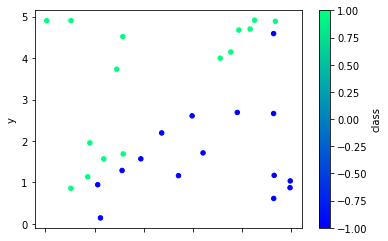

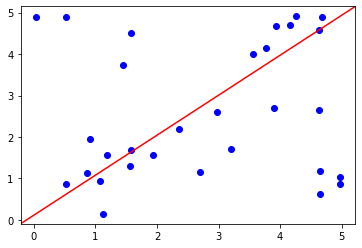

In [137]:
df.plot.scatter('x', 'y', c='class', colormap='winter')
xs = np.linspace(0, 5, 1000)

In [110]:
def calculate_h(w, point):
    return sum([w[j] * point[j] for j in range(0, len(w))])


def calculate_o(h):
    return 1 if h > 0 else -1


def calculate_error(data, w):
    err = 0
    for index, row in data.iterrows():
        h = calculate_h(w, row)
        o = calculate_o(h)
        err += abs(row['class'] - o)
    return err


def get_weights(data, eta=0.1, iterations=1000, stdout=False):
    i = 0
    w = [0 for i in range(len(data.loc[0]) - 1)]
    w_min = w
    error = 1
    error_min = len(df)
    threshold = w[0]  # TODO: ask
    
    while error > 0 and i < iterations:
        random_index = rng.integers(0, len(data))
        point = data.iloc[random_index]
        h = calculate_h(w, point)
        o = calculate_o(h)
        delta_w = eta * (point['class'] - o) * point[0:len(point) - 1]
        w += delta_w
        error = calculate_error(data, w)
        if error < error_min:
            error_min = error
            w_min = w
        
        i += 1
        
        if stdout:
            print(f"error: {error}; point: {list(point)}; h: {h}; o: {o}; delta_w: {list(delta_w)}; w: {list(w)}")
    
    return w_min, error_min

In [112]:
ws, err_m = get_weights(df)
print(f"\n\n\n\n\n{err_m}")
print(ws)






0.0
x   -1.569873
y    1.643629
Name: 20, dtype: float64


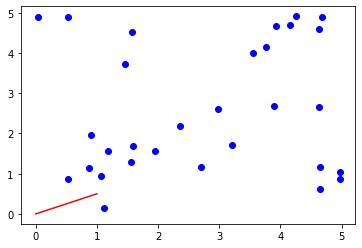

In [141]:
fig, ax = plt.subplots()
ax.scatter(list(df['x']), list(df['y']), c='Blue')
yi = 0
yf = 5
ax.plot([0, 1], [0, 0.5], color='Red')#, transform=ax.transAxes)

In [128]:
def classify(x, y, w):
    h = calculate_h(w, (x, y))
    o = calculate_o(h)
    return o

print(classify(, 4.98, ws))

1
